## Setup

In [137]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from td.client import TDClient
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split, GridSearchCV,\
    cross_val_score, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, plot_confusion_matrix,\
    precision_score, recall_score, accuracy_score, f1_score, log_loss,\
    roc_curve, roc_auc_score, classification_report, plot_roc_curve
from imblearn.under_sampling import TomekLinks
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler
from sklearn.pipeline import Pipeline
import xgboost
# from code.functions import *
%matplotlib inline

In [5]:
pd.set_option('display.max_columns',None)

In [207]:
df = pd.read_csv('data/cmc.data', names = ['age','edu','hus_edu','chil','rel','work',
                                        'hus_ocu','sol','media','cmc'])

In [133]:
df

,age,edu,hus_edu,chil,rel,work,hus_ocu,sol,media,cmc
0,24,2,3,3,1,1,2,3,0,1
1,45,1,3,10,1,1,3,4,0,1
2,43,2,3,7,1,1,3,4,0,1
3,42,3,2,9,1,1,3,3,0,1
4,36,3,3,8,1,1,3,2,0,1
...,...,...,...,...,...,...,...,...,...,...
1468,33,4,4,2,1,0,2,4,0,3
1469,33,4,4,3,1,1,1,4,0,3
1470,39,3,3,8,1,0,1,4,0,3
1471,33,3,3,4,1,0,2,2,0,3


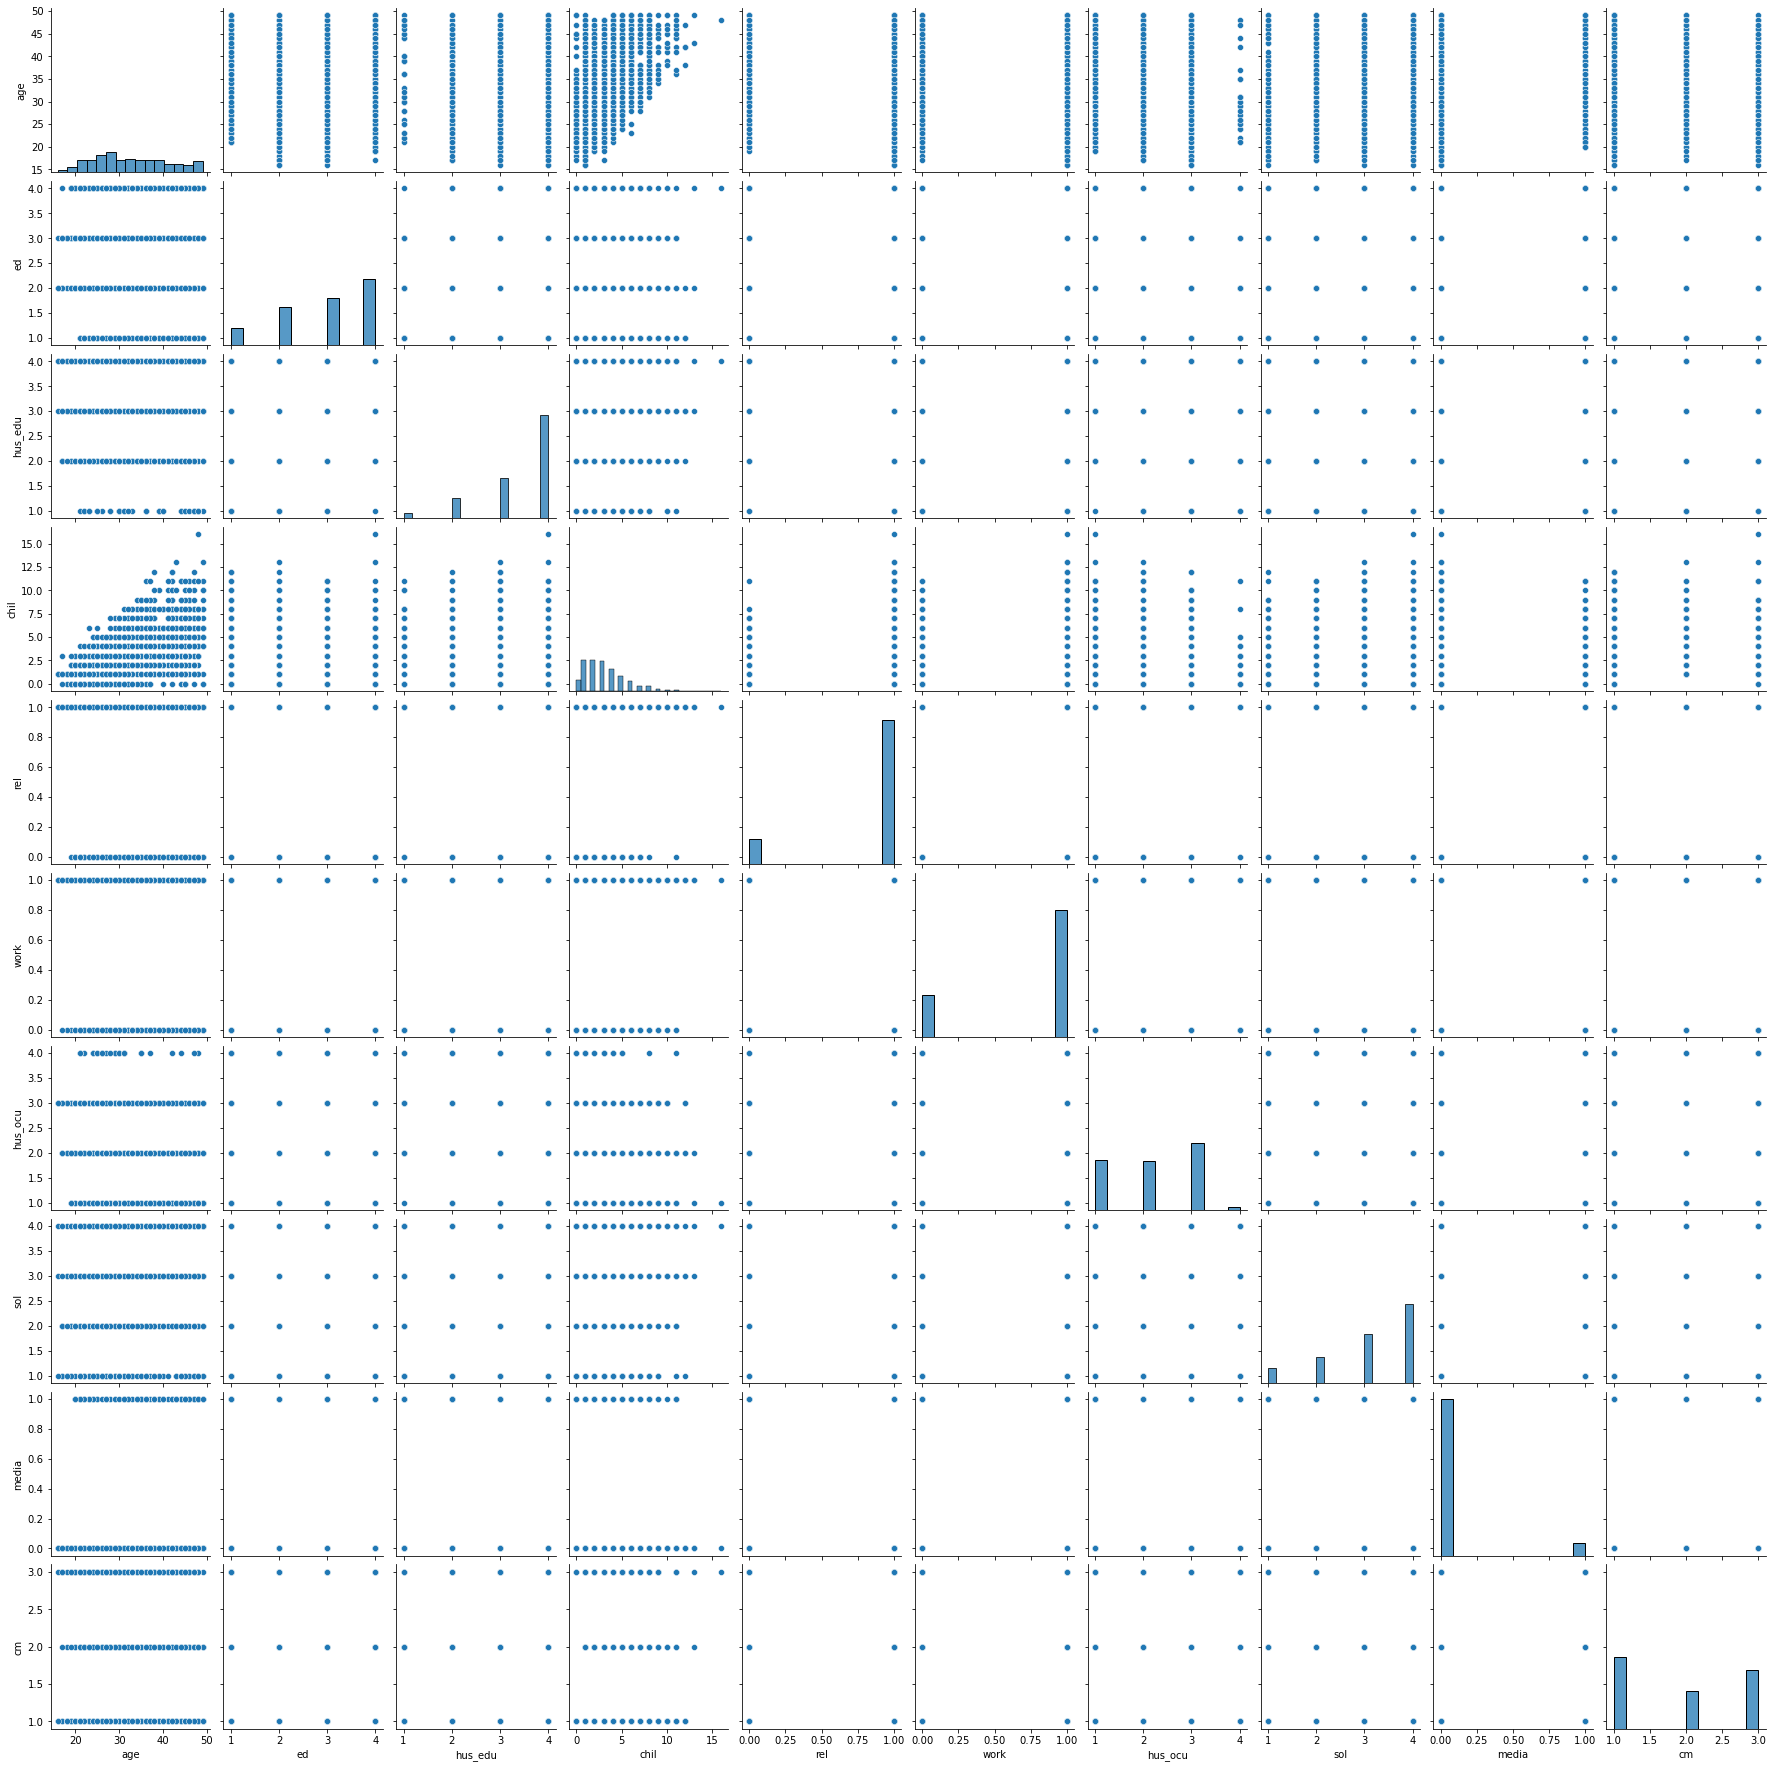

In [12]:
sns.pairplot(cmc)

In [18]:
df.isna().sum()

age        0
ed         0
hus_edu    0
chil       0
rel        0
work       0
hus_ocu    0
sol        0
media      0
cm         0
dtype: int64

In [105]:
df.cmc.value_counts()

1    629
3    511
2    333
Name: cmc, dtype: int64

Questions:  
ad spending or government spending on health education, to better target demographics who are not likely to use short or long-term contraceptive methods  
each row represents a person  
target variable is contraceptive method

# EDA

In [36]:
def feature_plot(df, ind, dep, plot_type, xlabel, xlog = 'n', ylog = 'n', color = u'#1f77b4'):
    ylabel = f'Contraception Method'
    title = f'{ylabel} vs {xlabel}'
    file_name = f'{xlabel}.png'
    fig, ax = plt.subplots(figsize = [12,8])
    if plot_type == 'scatter':
        sns_obj = sns.scatterplot(data = df, x=ind, y=dep, ax=ax, color = color)
    elif plot_type == 'line':
        sns_obj = sns.lineplot(data = df, x=ind, y=dep, color = color)
    if xlog == 'y':
        set_x_log(sns_obj, ax)
    if ylog == 'y':
        set_y_log(sns_obj, ax)
    # what color is u'#1f77b4'? what color is None?
    ax.set_title(title, fontdict = {'fontsize': 14})
    ax.set_xlabel(xlabel, fontdict = {'fontsize': 12})
    ax.set_ylabel(ylabel, fontdict = {'fontsize': 12})
    plt.savefig(f'visualizations/{file_name}')

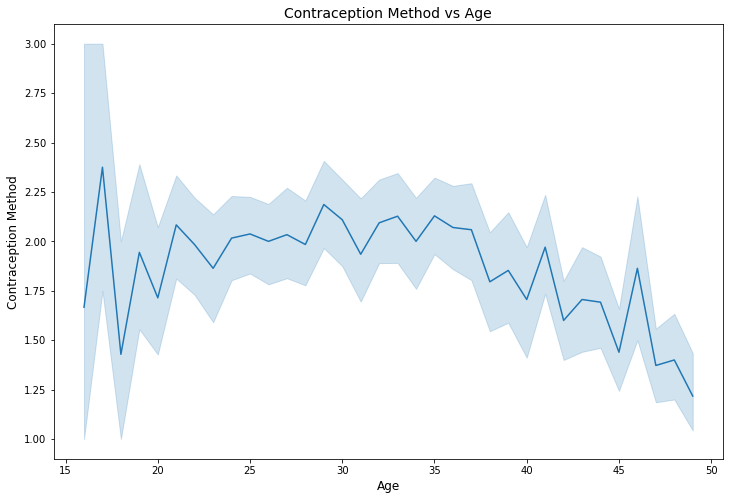

In [44]:
feature_plot(df, df.age, y, 'line', 'Age', xlog = 'n', ylog = 'n', color = u'#1f77b4')

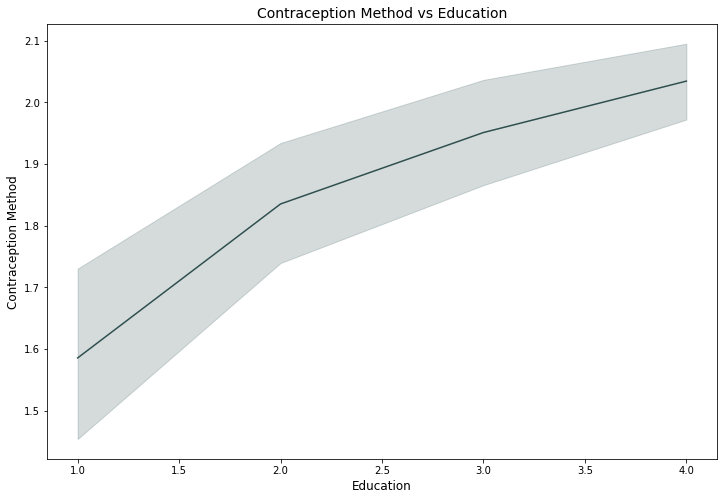

In [97]:
feature_plot(df, df.edu, y, 'line', 'Education', color = 'darkslategray')

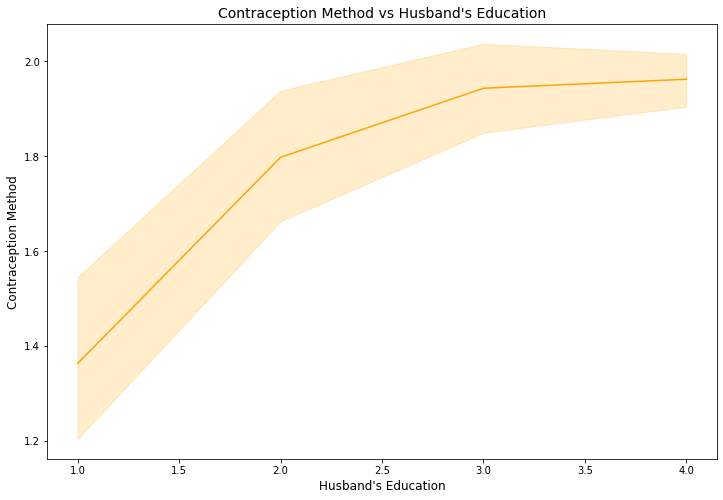

In [98]:
feature_plot(df, df.hus_edu, y, 'line', 'Husband\'s Education', color = 'orange')

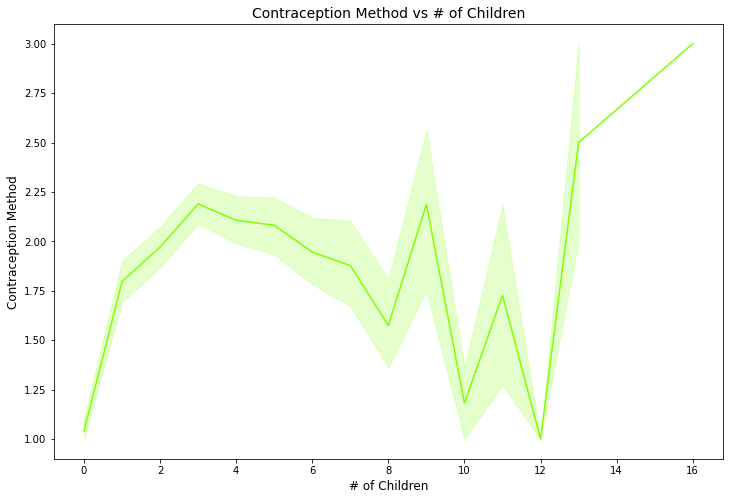

In [95]:
feature_plot(df, df.chil, y, 'line', '# of Children', color = 'chartreuse')

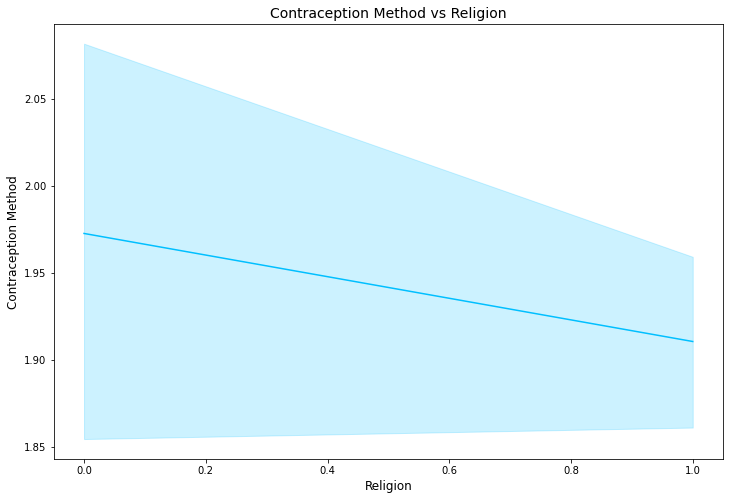

In [101]:
feature_plot(df, df.rel, y, 'line', 'Religion', color = 'deepskyblue')

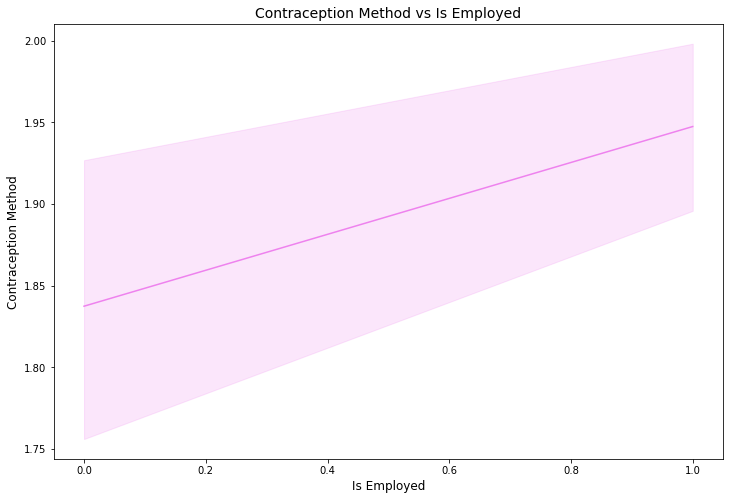

In [102]:
feature_plot(df, df.work, y, 'line', 'Is Employed', color = 'violet')

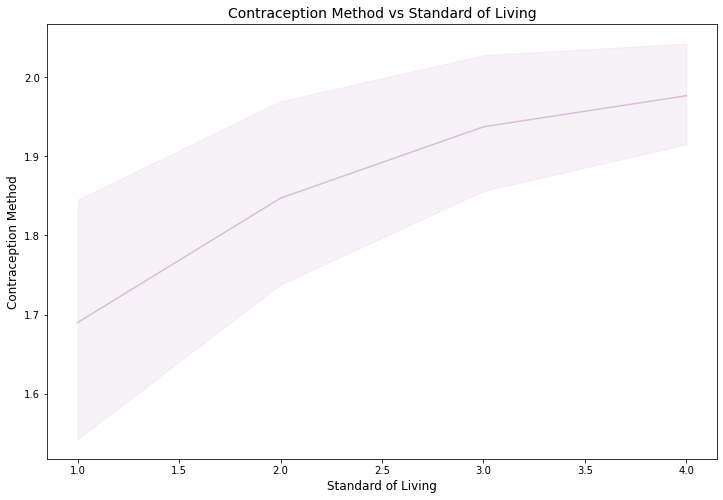

In [106]:
feature_plot(df, df.sol, y, 'line', 'Standard of Living', color = 'thistle')

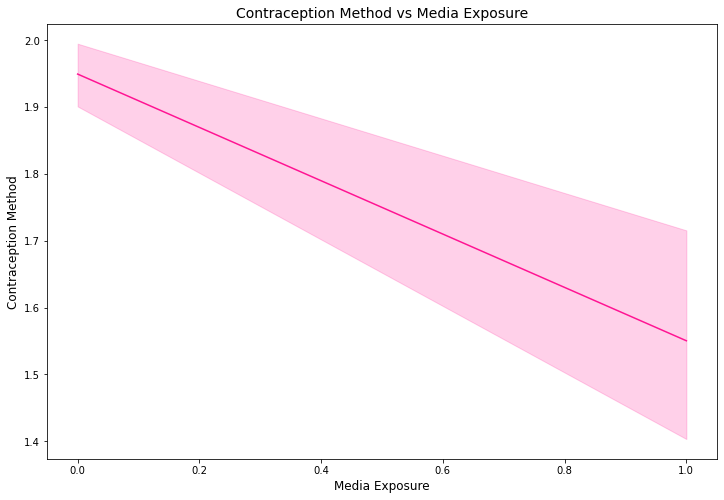

In [108]:
feature_plot(df, df.media, y, 'line', 'Media Exposure', color = 'deeppink')

In [ ]:
# find menopause data for 1987

In [131]:
# hist, box, violin, bar
df

,age,edu,hus_edu,chil,rel,work,hus_ocu,sol,media
0,24,2,3,3,1,1,2,3,0
1,45,1,3,10,1,1,3,4,0
2,43,2,3,7,1,1,3,4,0
3,42,3,2,9,1,1,3,3,0
4,36,3,3,8,1,1,3,2,0
...,...,...,...,...,...,...,...,...,...
1468,33,4,4,2,1,0,2,4,0
1469,33,4,4,3,1,1,1,4,0
1470,39,3,3,8,1,0,1,4,0
1471,33,3,3,4,1,0,2,2,0


# Feature Engineering

In [208]:
X = df.copy()
y = X.pop('cmc')

## Dumying

In [209]:
to_dummy = ['edu', 'hus_edu', 'chil', 'hus_ocu', 'sol']
features = X.columns
X_with_dums = pd.get_dummies(df, columns=to_dummy)
X_with_dums.shape

(1473, 36)

## Split data into train and test sets

In [210]:
X_train, X_test, y_train, y_test = train_test_split(
    X_with_dums, y, test_size=.25,
    random_state=1)
X_train.shape

(1104, 36)

## Scale features

In [211]:
rs = RobustScaler()

rs.fit(X_train)
X_train = rs.transform(X_train)
X_test = rs.transform(X_test)

In [212]:
X_train.mean().mean()

0.08156898024910447

## Label encode categorical variables - not working

In [119]:
# ['age','edu','hus_edu','chil','rel','work', 'hus_ocu','sol','media','cmc'])
label_encoder = LabelEncoder()
mappings = []

# 1 — did not go to school
# 2 — some primary school
# 3 — graduated from primary school with no further education
# 4 — secondary or higher education

# Desired label orders for categorical columns.
edu_order = ['none', 'some_prim', 'prim', 'sec+']
hus_edu_oder = ['none', 'some_prim', 'prim', 'sec+']

# using cat.codes for order, one hot for high cardinality and weak case of cardinality.

def ordered_labels(df, col, order):
    df[col] = df[col].astype('category')
    df[col] = df[col].cat.reorder_categories(order, ordered=True)
    df[col] = df[col].cat.codes.astype(int)

# Use dummy variables for husband occupation
X = pd.concat([X, pd.get_dummies(X['hus_ocu'])],axis=1).drop('hus_ocu',axis=1)

# Use ordered cat.codes for education, husband education
ordered_labels(X, 'edu', edu_order)
ordered_labels(X, 'hus_edu', hus_edu_oder)

# Same label encoding for rest since low cardinality
# for i, col in enumerate(X):
#     if X_df[col].dtype == 'object':
#         X_df[col] = label_encoder.fit_transform(np.array(X[col].astype(str)).reshape((-1,)))
#         mappings.append(dict(zip(label_encoder.classes_, range(1, len(label_encoder.classes_)+1))))

X.head()

ValueError: items in new_categories are not the same as in old categories

In [ ]:
# keep age continuous
# create new variable 18 or younger

# Modeling

## Functions

In [ ]:
def grid_search(model_type, X, y):
    if model_type == log:
        model = LogisticRegression()
        params_grid = {
            'multi_class': 'multinomial',
            'solver': ['liblinear'],
            'penalty': ['l1', 'l2'],
            'C': np.logspace(-4, 4, 20),
            'l1_ratio': stats.expon(scale=0.2),
        }
    elif model_type = dtc:
        model = DecisionTreeClassifier()
        params_grid = {
            'criterion': ['gini', 'entropy'],
            'max_depth': [None, 5, 3, 2],
            'min_samples_split': [2, 10, 20]
        }
    elif model_type = knn:
        model = KNeighborsClassifier()

    gridsearch_model = GridSearchCV(estimator=model_type, param_grid=params_grid)

    gridsearch_model.fit(X_train, y_train)
    print(gridsearch_model.best_params_)
    best_model = gridsearch_model.best_estimator_
    best_model.score(X_test, y_test)

In [213]:
def log_reg(X_train, X_test, y_train, y_test):
    # Split data into train and test sets
#     X_train, X_test, y_train, y_test = train_test_split(
#         X, y, test_size=.25,
#         random_state=1)
    
    # Scale the data for modeling
#     log_scaler = StandardScaler()
#     log_scaler.fit(X_train)
#     X_train_sc = log_scaler.transform(X_train)
#     X_test_sc = log_scaler.transform(X_test)
    
    # Train a logistic regression model with the train data
    log_model = LogisticRegression(multi_class='multinomial', solver='lbfgs'
#                                    solver='liblinear',
#                                    C=.001,
#                                    class_weight = 'balanced'
                                  )
    log_model.fit(X_train, y_train)
    y_pred = log_model.predict(X_test)
    y_prob = log_model.predict_proba(X_test)
    model_stats(X.columns, log_model, X_test, y_test, y_pred, y_prob)
    return log_model

In [214]:
def model_stats(features, model, X_test, y_test, y_pred, y_prob):
    print('Num features: ', features.size)
    print('Model score: ', model.score(X_test, y_test))
    print('Model F1 (micro): ', f1_score(y_test, y_pred, average='micro'))
    print('Model F1 (macro): ', f1_score(y_test, y_pred, average='macro'))
    print('Model F1 (weighted): ', f1_score(y_test, y_pred, average='weighted'))
    print('Cross validation score: ', cross_val_score(model, X_test, y_test, cv=5) )
    print('Classification Report:')
    print(classification_report(y_test, y_pred))
    fig, ax = plt.subplots(figsize = [6,8])
    plot_confusion_matrix(model, X_test, y_test, ax = ax)
#     plot_roc_curve(model, X_test_sc, y_test, ax = ax[1])
    macro_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                  average="macro")
    weighted_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo",
                                         average="weighted")
    macro_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                      average="macro")
    weighted_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr",
                                         average="weighted")
    print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
          "(weighted by prevalence)"
          .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
    print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
          "(weighted by prevalence)"
          .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

## Logistic Regression - Base Model

Num features:  9
Model score:  1.0
Model F1 (micro):  1.0
Model F1 (macro):  1.0
Model F1 (weighted):  1.0
Cross validation score:  [1.         0.95945946 0.97297297 0.97297297 0.98630137]
Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       161
           2       1.00      1.00      1.00        87
           3       1.00      1.00      1.00       121

    accuracy                           1.00       369
   macro avg       1.00      1.00      1.00       369
weighted avg       1.00      1.00      1.00       369

One-vs-One ROC AUC scores:
1.000000 (macro),
1.000000 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
1.000000 (macro),
1.000000 (weighted by prevalence)


LogisticRegression(multi_class='multinomial')

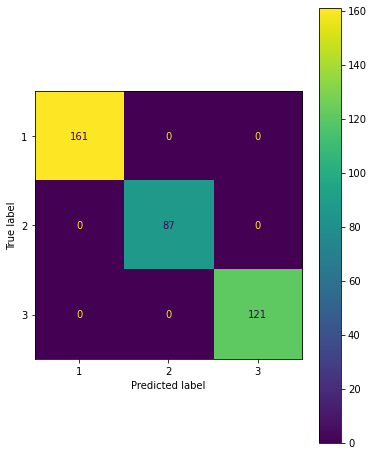

In [215]:
log_reg(X_train, X_test, y_train, y_test)

## Pipeline

In [ ]:
# Create first pipeline for base without reducing features.

pipe = Pipeline([('rfc' , RandomForestClassifier())])

# Create param grid
params_grid = [
    {'rfc' : [LogisticRegression()],
     'rfc__penalty' : ['l1', 'l2'],
    'rfc__C' : np.logspace(-4, 4, 20),
    'rfc__solver' : ['liblinear']},
    {'rfc' : [RandomForestClassifier()],
    'rfc__n_estimators' : list(range(10,101,10)),
    'rfc__max_features' : list(range(6,32,5))}
]

# Create grid search object
clf = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)

# Fit on data
best_clf = clf.fit(X_train, y_train)

## With Tomek Link resampling

In [ ]:
tl = TomekLinks()
X_res, y_res = tl.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))